In [1]:
import imgaug
import cv2


import os


from keras.preprocessing import image
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping


from keras.utils import plot_model, Sequence
from keras.metrics import MeanIoU


from keras.models import Model


from keras.layers import UpSampling2D, Input, Conv2D, MaxPooling2D, Concatenate
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import random
import numpy as np


import tensorflow as tf
import warnings
import mlflow

warnings.filterwarnings('ignore')

# Utils

In [2]:
from tensorflow.keras.utils import Sequence, to_categorical, load_img, img_to_array

import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
from PIL import UnidentifiedImageError
from collections import namedtuple
import utils


Label = namedtuple('Label', [
    'name', 'id', 'trainId', 'category', 'catId',
    'hasInstances', 'ignoreInEval', 'color',
])

# Exemple de labels (complétez avec l'ensemble complet des labels définis dans votre labels.py)
labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label('unlabeled',  0,      255, 'void', 0, False, True, (0,  0,  0)),
    Label('ego vehicle',  1,      255, 'void', 0, False, True, (0,  0,  0)),
    Label('rectification border',  2,      255,
          'void', 0, False, True, (0,  0,  0)),
    Label('out of roi',  3,      255, 'void', 0, False, True, (0,  0,  0)),
    Label('static',  4,      255, 'void', 0, False, True, (0,  0,  0)),
    Label('dynamic',  5,      255, 'void', 0, False, True, (111, 74,  0)),
    Label('ground',  6,      255, 'void', 0, False, True, (81,  0, 81)),
    Label('road',  7,        0, 'flat', 1, False, False, (128, 64, 128)),
    Label('sidewalk',  8,        1, 'flat', 1, False, False, (244, 35, 232)),
    Label('parking',  9,      255, 'flat', 1, False, True, (250, 170, 160)),
    Label('rail track', 10,      255, 'flat', 1, False, True, (230, 150, 140)),
    Label('building', 11,        2, 'construction',
          2, False, False, (70, 70, 70)),
    Label('wall', 12,        3, 'construction',
          2, False, False, (102, 102, 156)),
    Label('fence', 13,        4, 'construction',
          2, False, False, (190, 153, 153)),
    Label('guard rail', 14,      255, 'construction',
          2, False, True, (180, 165, 180)),
    Label('bridge', 15,      255, 'construction',
          2, False, True, (150, 100, 100)),
    Label('tunnel', 16,      255, 'construction',
          2, False, True, (150, 120, 90)),
    Label('pole', 17,        5, 'object', 3, False, False, (153, 153, 153)),
    Label('polegroup', 18,      255, 'object',
          3, False, True, (153, 153, 153)),
    Label('traffic light', 19,        6, 'object',
          3, False, False, (250, 170, 30)),
    Label('traffic sign', 20,        7, 'object',
          3, False, False, (220, 220,  0)),
    Label('vegetation', 21,        8, 'nature',
          4, False, False, (107, 142, 35)),
    Label('terrain', 22,        9, 'nature', 4, False, False, (152, 251, 152)),
    Label('sky', 23,       10, 'sky', 5, False, False, (70, 130, 180)),
    Label('person', 24,       11, 'human', 6, True, False, (220, 20, 60)),
    Label('rider', 25,       12, 'human', 6, True, False, (255,  0,  0)),
    Label('car', 26,       13, 'vehicle', 7, True, False, (0,  0, 142)),
    Label('truck', 27,       14, 'vehicle', 7, True, False, (0,  0, 70)),
    Label('bus', 28,       15, 'vehicle', 7, True, False, (0, 60, 100)),
    Label('caravan', 29,      255, 'vehicle', 7, True, True, (0,  0, 90)),
    Label('trailer', 30,      255, 'vehicle', 7, True, True, (0,  0, 110)),
    Label('train', 31,       16, 'vehicle', 7, True, False, (0, 80, 100)),
    Label('motorcycle', 32,       17, 'vehicle', 7, True, False, (0,  0, 230)),
    Label('bicycle', 33,       18, 'vehicle', 7, True, False, (119, 11, 32)),
    Label('license plate', -1,       -1,
          'vehicle', 7, False, True, (0,  0, 142)),
]
# Création du mapping id vers categoryId
id_to_category_id_mapping = {label.id: label.catId for label in labels}


class seg_gen(Sequence):
    def __init__(self, x_set, y_set, batch_size=16, with_data_augmentation=False, num_classes=8):
        self.x, self.y = x_set, y_set
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.with_data_augmentation = with_data_augmentation
        if self.with_data_augmentation:
            self.augmenter = self._get_augmenter()

        if self.with_data_augmentation:
            self.augmentation = iaa.Sequential([
                iaa.Fliplr(0.5),  # Horizontal flips
                iaa.Affine(
                    # Random rotations between -10 and 10 degrees
                    rotate=(-10, 10),
                    # Random shearing between -5 and 5 degrees
                    shear=(-5, 5),
                    # Random scaling between 80% and 120%
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}
                ),
                # Gaussian blur with random sigma
                iaa.GaussianBlur(sigma=(0, 1.0))
            ])

    def __len__(self):
        return np.ceil(len(self.x) / self.batch_size).astype(int)

    def __getitem__(self, idx):
        batch_x_paths = self.x[idx *
                               self.batch_size:(idx + 1) * self.batch_size]
        batch_y_paths = self.y[idx *
                               self.batch_size:(idx + 1) * self.batch_size]

        batch_x, batch_y = [], []

        for x_path, y_path in zip(batch_x_paths, batch_y_paths):
            img = self._load_image(x_path)
            mask = self._load_mask(y_path)

            if self.with_data_augmentation:
                img, mask = self._augment_image_and_mask(img, mask)

            batch_x.append(img)
            batch_y.append(mask)

        return np.array(batch_x), np.array(batch_y)

    def _load_image(self, file_name):
        try:
            img = load_img(file_name, target_size=(256, 256))
            img = img_to_array(img)/255
            return img
        except UnidentifiedImageError:
            print(f"Erreur en chargeant l'image : {file_name}")
            raise

    def _load_mask(self, mask_file):
        mask = load_img(mask_file, color_mode='grayscale',
                        target_size=(256, 256))
        mask = img_to_array(mask).astype(int)

        mapped_mask = self._map_labels_to_classes(mask[:, :, 0])

        one_hot_mask = to_categorical(
            mapped_mask, num_classes=self.num_classes)

        return one_hot_mask

    def _map_labels_to_classes(self, mask):

        id_to_category_id_mapping = {
            0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 1, 8: 1, 9: 1, 10: 1, 11: 2,
            12: 2, 13: 2, 14: 2, 15: 2, 16: 2, 17: 3, 18: 3, 19: 3, 20: 3, 21: 4,
            22: 4, 23: 5, 24: 6, 25: 6, 26: 7, 27: 7, 28: 7, 29: 7, 30: 7, 31: 7,
            32: 7, 33: 7, -1: 7}

        mapped_mask = np.vectorize(id_to_category_id_mapping.get)(mask)

        return mapped_mask

    def _get_augmenter(self):
        """ Create augmentation sequence"""
        return iaa.Sequential([
            iaa.Fliplr(0.5),
            iaa.Affine(rotate=(-10, 20)),
            iaa.Multiply((0.8, 1.2))
        ])

    def _augment_image_and_mask(self, image, mask):
        # Assurez-vous que le masque est booléen ou entier
        mask = mask.astype(np.int32)

        # Convertissez le masque en SegmentationMapsOnImage
        segmap = SegmentationMapsOnImage(mask, shape=image.shape)

        # Appliquez l'augmentation à l'image et au masque
        image_aug, segmaps_aug = self.augmenter(
            image=image.astype(np.uint8), segmentation_maps=segmap)

        # Convertissez le résultat en format approprié
        image_aug = image_aug.astype(np.float32) / 255.0
        mask_aug = segmaps_aug.get_arr().astype(np.float32)

        return image_aug, mask_aug

## Mapping labelsId-catIds

In [3]:
# Load images and masks
image_dir = './Datasets/Images/leftImg8bit/train/'
mask_dir = './Datasets/Masks/gtFine/train'

image_val_dir = './Datasets/Images/leftImg8bit/val'
mask_val_dir = './Datasets/Masks/gtFine/val'

image_test_dir = "./Datasets/Images/leftImg8bit/test"
mask_test_dir = './Datasets/Masks/gtFine/test'

image_list = [file for file in utils.get_file_list(
    image_dir) if file.endswith('_leftImg8bit.png')]
mask_list = [file for file in utils.get_file_list(
    mask_dir) if file.endswith('_labelIds.png')]

image_val_list = [file for file in utils.get_file_list(
    image_val_dir) if file.endswith('_leftImg8bit.png')]
mask_val_list = [file for file in utils.get_file_list(
    mask_val_dir) if file.endswith('_labelIds.png')]

image_test_list = [file for file in utils.get_file_list(
    image_test_dir) if file.endswith('_leftImg8bit.png')]
mask_test_list = [file for file in utils.get_file_list(
    mask_test_dir) if file.endswith('_labelIds.png')]

print(
    f'Images répertoriées: {len(image_list)}n/nMasques répertoriés: {len(mask_list)}')
print(
    f"Nombre d/'images de validation : {len(image_val_list)}n/nNombre de masques de validation répertoriés : {len(mask_val_list)}")
print(
    f"Nombre d/'images de test : {len(image_test_list)}n/nNombre de masques de test : {len(mask_test_list)}")

batch_size = 16
samples = len(image_list)
steps = samples // batch_size
img_height, img_width = 256, 256
classes = 8
filters_n = 64

Images répertoriées: 2975n/nMasques répertoriés: 2975
Nombre d/'images de validation : 500n/nNombre de masques de validation répertoriés : 500
Nombre d/'images de test : 1525n/nNombre de masques de test : 1525


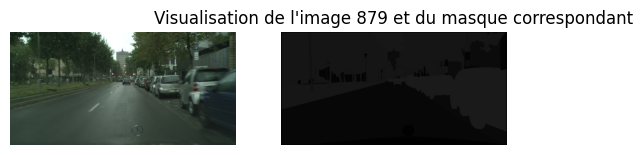

In [4]:
# Valide le chargement des données par visualisation d'un échantillon aléatoire
i = np.random.randint(0, len(image_list))

plt.subplot(1, 2, 1)
plt.imshow(load_img(image_list[i]))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(load_img(mask_list[i]))
plt.axis('off')
plt.title(f"Visualisation de l'image {i} et du masque correspondant")
plt.show()

## Modélisation Seg_gen + entrainement


In [6]:
import gc
gc.collect()

3945

In [5]:
# Sans data augmentation
train_gen = seg_gen(image_list, mask_list, batch_size=32,
                    with_data_augmentation=False)


test_gen = seg_gen(image_test_list, mask_test_list,
                   batch_size=32, with_data_augmentation=False)


val_gen = seg_gen(image_val_list, mask_val_list,
                  batch_size=32, with_data_augmentation=False)

print("DataGenerator OK")

DataGenerator OK


In [6]:
# Définition de dice_loss
from tensorflow.keras.utils import register_keras_serializable


@register_keras_serializable()
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
   Fonction de perte de Dice pour la segmentation sémantique.
    Args:
    y_true (tensor): Tensor des étiquettes réelles.
    y_pred (tensor): Tensor des prédictions du modèle.
    smooth (float): Terme de lissage pour éviter la division par zéro.
    Returns:
    float: Perte de Dice.
    """

    # Aplatir les tensors

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2])

    union = tf.reduce_sum(
        y_true, axis=[1, 2]) + tf.reduce_sum(y_pred, axis=[1, 2])

    dice = (2. * intersection + smooth) / (union + smooth)

    dice_loss = 1 - tf.reduce_mean(dice, axis=-1)

    return dice_loss

# Modélisation

## Baseline

In [7]:
# Construction et entrainement du modèle baseline
meanIoU = MeanIoU(num_classes=classes)

mc_base = ModelCheckpoint(mode='min', filepath='baseline_model.keras',
                          save_freq="epoch", monitor='val_loss',
                          save_best_only=True, save_weights_only=False,
                          verbose=1)
es_base = EarlyStopping(mode='min', monitor='val_loss',
                        patience=3, verbose=1)


print("Callbacks OK")

# Création du modèle baseline


baseline_model = utils.baseline_model(img_height, img_width, classes)
baseline_model.compile(optimizer='adam', loss=dice_loss,
                       metrics=[MeanIoU(num_classes=8), 'accuracy'])


callbacks_base = [mc_base, es_base]
mlflow.set_experiment('Baseline_training')
mlflow.autolog()
baseline_model.fit(train_gen,
                   epochs=10,
                   validation_data=val_gen,
                   callbacks=callbacks_base
                   )

print("#------------Entrainement terminé-----------------")

Callbacks OK


2024/04/20 17:09:28 INFO mlflow.tracking.fluent: Experiment with name 'Baseline_training' does not exist. Creating a new experiment.
2024/04/20 17:09:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/04/20 17:09:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/04/20 17:09:28 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/04/20 17:09:28 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/04/20 17:09:28 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/04/20 17:09:28 INFO mlflow.

2024/04/20 17:09:44 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Metric 'desktop.ini' is malformed; persisted metric data contained 1 fields. Expected 2 or 3 fields.


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.4153 - loss: 0.8445 - mean_io_u_1: 0.4502 
Epoch 1: val_loss improved from inf to 0.70602, saving model to baseline_model.keras


2024/04/20 17:47:54 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Metric 'desktop.ini' is malformed; persisted metric data contained 1 fields. Expected 2 or 3 fields.


93/93 ━━━━━━━━━━━━━━━━━━━━ 2290s 24s/step - accuracy: 0.4160 - loss: 0.8439 - mean_io_u_1: 0.4507 - val_accuracy: 0.5729 - val_loss: 0.7060 - val_mean_io_u_1: 0.6211
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.5778 - loss: 0.6939 - mean_io_u_1: 0.6077 
Epoch 2: val_loss improved from 0.70602 to 0.67002, saving model to baseline_model.keras


2024/04/20 18:24:05 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Metric 'desktop.ini' is malformed; persisted metric data contained 1 fields. Expected 2 or 3 fields.


93/93 ━━━━━━━━━━━━━━━━━━━━ 2171s 23s/step - accuracy: 0.5779 - loss: 0.6938 - mean_io_u_1: 0.6077 - val_accuracy: 0.6084 - val_loss: 0.6700 - val_mean_io_u_1: 0.6298
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6146 - loss: 0.6604 - mean_io_u_1: 0.6309 
Epoch 3: val_loss improved from 0.67002 to 0.59846, saving model to baseline_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 2156s 23s/step - accuracy: 0.6149 - loss: 0.6602 - mean_io_u_1: 0.6311 - val_accuracy: 0.7001 - val_loss: 0.5985 - val_mean_io_u_1: 0.7176
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.6820 - loss: 0.6014 - mean_io_u_1: 0.7001 
Epoch 4: val_loss improved from 0.59846 to 0.58146, saving model to baseline_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 2050s 22s/step - accuracy: 0.6821 - loss: 0.6014 - mean_io_u_1: 0.7002 - val_accuracy: 0.6713 - val_loss: 0.5815 - val_mean_io_u_1: 0.7073
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7080 - loss: 0.5778 - mean_io_u_1: 0.7245 
Epoch 5: val_loss improved from 0.58146 to 0.56129, saving model to baseline_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 2043s 22s/step - accuracy: 0.7080 - loss: 0.5777 - mean_io_u_1: 0.7245 - val_accuracy: 0.7152 - val_loss: 0.5613 - val_mean_io_u_1: 0.7376
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7170 - loss: 0.5731 - mean_io_u_1: 0.7339 
Epoch 6: val_loss did not improve from 0.56129
93/93 ━━━━━━━━━━━━━━━━━━━━ 2053s 22s/step - accuracy: 0.7170 - loss: 0.5731 - mean_io_u_1: 0.7339 - val_accuracy: 0.7070 - val_loss: 0.5691 - val_mean_io_u_1: 0.7326
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7224 - loss: 0.5638 - mean_io_u_1: 0.7389 
Epoch 7: val_loss improved from 0.56129 to 0.55569, saving model to baseline_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 2050s 22s/step - accuracy: 0.7225 - loss: 0.5637 - mean_io_u_1: 0.7389 - val_accuracy: 0.7253 - val_loss: 0.5557 - val_mean_io_u_1: 0.7398
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 20s/step - accuracy: 0.7513 - loss: 0.5327 - mean_io_u_1: 0.7610 
Epoch 8: val_loss improved from 0.55569 to 0.52377, saving model to baseline_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 2044s 22s/step - accuracy: 0.7514 - loss: 0.5326 - mean_io_u_1: 0.7611 - val_accuracy: 0.7452 - val_loss: 0.5238 - val_mean_io_u_1: 0.7573
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 94s/step - accuracy: 0.7646 - loss: 0.5145 - mean_io_u_1: 0.7706  
Epoch 9: val_loss improved from 0.52377 to 0.50886, saving model to baseline_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 8806s 95s/step - accuracy: 0.7647 - loss: 0.5145 - mean_io_u_1: 0.7707 - val_accuracy: 0.7666 - val_loss: 0.5089 - val_mean_io_u_1: 0.7758
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.7851 - loss: 0.5037 - mean_io_u_1: 0.7871 
Epoch 10: val_loss improved from 0.50886 to 0.49978, saving model to baseline_model.keras


93/93 ━━━━━━━━━━━━━━━━━━━━ 2449s 26s/step - accuracy: 0.7850 - loss: 0.5037 - mean_io_u_1: 0.7871 - val_accuracy: 0.7746 - val_loss: 0.4998 - val_mean_io_u_1: 0.7796


2024/04/21 00:58:15 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2024/04/21 00:58:15 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


#------------Entrainement terminé-----------------


# Visualisation


In [ ]:
loaded_model = tf.keras.models.load_model(
    'baseline_simple.keras', custom_objects={'dice_loss': dice_loss})

In [8]:
baseline_model.save('baseline_simple.keras', save_format='tf')

In [10]:
baseline_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │    524,544 │ conv2d_3[0][0]    │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │  1,179,904 │ concatenate[0][0] │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 128, 128,  │    131,200 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 128, 128,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    295,040 │ concatenate_1[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 256, 256,  │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256, 256,  │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 256, 256,  │     73,792 │ concatenate_2[0]

 Total params: 11,366,426 (43.36 MB)

 Trainable params: 3,788,808 (14.45 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,577,618 (28.91 MB)

In [ ]:
# Class_colors dictionnary for visualisation

class_colors = {
    0: (0, 0, 0),       # Classe 0 : Noir - Background/Void
    1: (128, 0, 0),     # Classe 1 : Rouge Foncé - Flat
    2: (0, 128, 0),     # Classe 2 : Vert Foncé - Sky
    3: (128, 128, 0),   # Classe 3 : Olive - Human
    4: (0, 0, 128),     # Classe 4 : Bleu Foncé - Vehicle
    5: (128, 0, 128),   # Classe 5 : Pourpre - Object
    6: (0, 128, 128),   # Classe 6 : Teal - Construction
    7: (128, 128, 128)  # Classe 7 : Gris - Nature
}

In [ ]:

def colorize_mask(mask, color_mapping):
    """
    Convertit un masque de segmentation en une image RGB en utilisant un mapping de couleurs.

    Args:
    mask (np.array): Un masque de segmentation avec la forme [height, width], contenant des indices de classe.
    color_mapping (dict): Un dictionnaire où les clés sont les indices de classe et les valeurs sont les couleurs RGB.

    Returns:
    np.array: Une image RGB colorisée du masque de segmentation.
    """
    colored_mask = np.zeros(
        (*mask.shape, 3), dtype=np.uint8)  # Créer une image RGB vide
    for class_index, color in color_mapping.items():
        # Appliquer la couleur pour chaque classe
        colored_mask[mask == class_index] = color
    return colored_mask

In [ ]:
image_test_list[0]
image_test = image.load_img(image_test_list[4])
image_test

In [ ]:
# Visualize predicted mask
image_test = image.img_to_array(image.load_img(
    image_test_list[4], target_size=(256, 256)))
prediction = baseline_model.predict(np.expand_dims(image_test, axis=0))
# Convertir de one-hot à indices de classe
predicted_classes = np.argmax(prediction, axis=-1)
# Coloriser le masque prédit
colored_mask = colorize_mask(predicted_classes, class_colors)


plt.imshow(np.squeeze(colored_mask))
plt.axis('off')
plt.show()

# Entrainement avec data augmentation
Nous cherchons à mesurer l'impact de la Data Augmentation dans la performance du modèle baseline et la qualité de l'entrainement

In [12]:
# DataGenerateur avec augmentation des données
train_gen_aug = seg_gen(image_list, mask_list, with_data_augmentation=True)
test_gen_aug = seg_gen(image_test_list, mask_test_list,
                       with_data_augmentation=True)
val_gen_aug = seg_gen(image_val_list, mask_val_list,
                      with_data_augmentation=True)
print('Generateur de données augmentées prêts.')

Generateur de données augmentées prêts.


In [ ]:
# Entrainement sur les données augmentées
# Baseline

meanIoU_aug = MeanIoU(num_classes=classes)
mc_base_aug = ModelCheckpoint(mode='min', filepath='baseline_aug_model.hdf5',
                              save_freq="epoch", monitor='val_loss',
                              save_best_only='True', save_weights_only='False',
                              verbose=1)

es_base_aug = EarlyStopping(mode='min', monitor='val_loss',
                            patience=3, verbose=1)

print("Callbacks OK")

# Création du modèle baseline
baseline_model = utils.baseline_model(img_height, img_width, classes)
baseline_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss=dice_loss,
                       metrics=[MeanIoU(num_classes=8), 'accuracy'])

callbacks_base_aug = [mc_base_aug, es_base_aug]


print('Entrainement...')

mlflow.set_experiment('Baseline training')
mlflow.autolog()
history_aug = baseline_model.fit(train_gen_aug,

                                 epochs=10,
                                 validation_data=val_gen_aug,
                                 callbacks=callbacks_base_aug,
                                 workers=-1)

print("#------------Entrainement terminé-----------------")

In [ ]:
# Evaluation
baseline_model.evaluate(test_gen_aug, verbose=2, return_dict=True)

# VGG16+Unet


In [13]:
# Définition du modèle
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.layers import Cropping2D, Dropout
from keras.optimizers import Adam


input_shape = (img_height, img_width, 3)


# input_tensor. Sans doute utile pour lier avec seg_gen/DataGenerator
VGG_model = VGG16(weights='imagenet', include_top=False,
                  input_shape=input_shape)
# for layer in VGG_model.layers:
#   layer.trainable = False

# Blocs de construction du modèle perso


def conv_block(inputs, filters, kernel_size=3, num_layers=8):  # Ajout d'un paramètre num_layers
    conv = inputs
    for _ in range(num_layers):  # Ajout de plusieurs couches de convolution
        conv = Conv2D(filters, kernel_size,
                      activation='relu', padding='same')(conv)
    return conv


# Ajout d'un paramètre num_layers
def encoder_block(inputs, filters, pool_size=(2, 2), num_layers=2):
    # Utilisation de conv_block avec le paramètre num_layers
    conv = conv_block(inputs, filters, num_layers=num_layers)
    pool = MaxPooling2D(pool_size)(conv)
    return conv, pool


# Ajout d'un paramètre num_layers
def decoder_block(inputs, skip_features, filters, kernel_size=3, upsample_size=(2, 2), num_layers=2):
    upsample = UpSampling2D(upsample_size)(inputs)
    skip_conv = Conv2D(filters, 1, activation='relu')(skip_features)
    skip_upsample = UpSampling2D(upsample_size)(skip_conv)
    concat = Concatenate(axis=-1)([upsample, skip_upsample])
    # Utilisation de conv_block avec le paramètre num_layers
    conv = conv_block(concat, filters, num_layers=num_layers)
    return conv

# Unet perso


def UNet(input_shape):
    inputs = Input(input_shape)

    conv1, pool1 = encoder_block(inputs, 64)
    droupout0 = Dropout(0.1, seed=42)(conv1)
    conv2, pool2 = encoder_block(pool1, 128)
    dropout1 = Dropout(rate=0.2, seed=42)(conv2)
    conv3, _ = encoder_block(pool2, 256)  # Discard the pool3 output

    bottleneck = conv_block(conv3, 512)

    up4 = decoder_block(bottleneck, conv3, 256)
    dropout3 = Dropout(rate=0.2, seed=42)(up4)
    up5 = decoder_block(up4, conv2, 128)
    dropout2 = Dropout(rate=0.2, seed=42)(up5)
    up6 = decoder_block(up5, conv1, 64)

    upsampled_output = UpSampling2D(size=(16, 16))(up6)
    output = Conv2D(8, 1, activation='softmax')(
        upsampled_output)  # 8 classes for segmentation

    model = Model(inputs=inputs, outputs=output)
    return model


UNet_model = UNet((None, None, 512))  # structures sorties VGG16

# Connexion VGG16-Unet perso

VGG_output = VGG_model.output
UNet_output = UNet_model(VGG_output)
print('----------Modèle hybride prêt-----------')

----------Modèle hybride prêt-----------


In [14]:
# Entrainement du modèle

mc_h = ModelCheckpoint(mode='min',
                       filepath='hybrid_model.keras', save_freq="epoch",
                       monitor='val_loss',
                       save_best_only=True,
                       save_weights_only=False,
                       verbose=1)

es_h = EarlyStopping(mode='min',
                     monitor='val_loss',
                     patience=3,
                     restore_best_weights=True,
                     verbose=1)


hybrid_model = Model(inputs=VGG_model.input, outputs=UNet_output)
hybrid_model.compile(optimizer=Adam(learning_rate=0.001),
                     loss=dice_loss,
                     metrics=[keras.metrics.MeanIoU(num_classes=8), 'accuracy'])

callbacks_h = [mc_h, es_h]

print("...Modèle généré. Début de l'entrainement...")

mlflow.set_experiment('Baseline_training')
mlflow.autolog()
hybrid_model.fit(train_gen,
                 epochs=10,
                 callbacks=callbacks_h,
                 validation_data=[val_gen]
                 )

print("#------------Entrainement terminé-----------------")

2024/04/17 07:42:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.
2024/04/17 07:42:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.
2024/04/17 07:42:48 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/04/17 07:42:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/04/17 07:42:48 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.
2024/04/17 07:42:48 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.


...Modèle généré. Début de l'entrainement...


2024/04/17 07:42:49 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'eb342d34684d4a4d9032b4c61ecbbb5f', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow
2024/04/17 07:42:49 WARNING mlflow.keras.autologging: Unrecognized dataset type <class '__main__.seg_gen'>. Dataset logging skipped.
2024/04/17 07:42:49 WARNING mlflow.keras.autologging: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3772 - loss: 0.8872 - mean_io_u_1: 0.5383
Epoch 1: val_loss improved from inf to 0.89694, saving model to hybrid_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1890s 10s/step - accuracy: 0.3772 - loss: 0.8873 - mean_io_u_1: 0.5383 - val_accuracy: 0.3661 - val_loss: 0.8969 - val_mean_io_u_1: 0.5372
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3838 - loss: 0.8927 - mean_io_u_1: 0.5378
Epoch 2: val_loss did not improve from 0.89694
186/186 ━━━━━━━━━━━━━━━━━━━━ 1861s 10s/step - accuracy: 0.3838 - loss: 0.8927 - mean_io_u_1: 0.5378 - val_accuracy: 0.3664 - val_loss: 0.8972 - val_mean_io_u_1: 0.5371
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3859 - loss: 0.8940 - mean_io_u_1: 0.5389
Epoch 3: val_loss improved from 0.89694 to 0.89670, saving model to hybrid_model.keras
186/186 ━━━━━━━━━━━━━━━━━━━━ 1828s 10s/step - accuracy: 0.3859 - loss: 0.8940 - mean_io_u_1: 0.5389 - val_accuracy: 0.3661 - v

In [1]:
# Nettoyage des fichiers desktop.ini créés en local
# A effectuer avant toute visualisation
import glob
import os

# Définir le chemin de base où rechercher les fichiers `desktop.ini`
base_path = "mlruns/**/desktop.ini"

# Utiliser `glob.glob` avec l'option `recursive=True` pour trouver tous les fichiers correspondants
# dans le dossier et ses sous-dossiers.
desktop_ini_files = glob.glob(base_path, recursive=True)

# Parcourir la liste des chemins de fichiers trouvés et les supprimer
for file_path in desktop_ini_files:
    os.remove(file_path)
    print(f"Deleted: {file_path}")

Deleted: mlruns\desktop.ini
Deleted: mlruns\models\desktop.ini
Deleted: mlruns\models\Hybrid\desktop.ini
Deleted: mlruns\models\Hybrid\version-1\desktop.ini
Deleted: mlruns\models\Hybrid\version-2\desktop.ini
Deleted: mlruns\models\baseline\desktop.ini
Deleted: mlruns\models\baseline\version-1\desktop.ini
Deleted: mlruns\0\desktop.ini
Deleted: mlruns\0\51015a2c293043acbcf9a015c8e0cda2\desktop.ini
Deleted: mlruns\0\51015a2c293043acbcf9a015c8e0cda2\tags\desktop.ini
Deleted: mlruns\0\51015a2c293043acbcf9a015c8e0cda2\artifacts\desktop.ini
Deleted: mlruns\0\51015a2c293043acbcf9a015c8e0cda2\params\desktop.ini
Deleted: mlruns\0\51015a2c293043acbcf9a015c8e0cda2\metrics\desktop.ini
Deleted: mlruns\267494163672902708\desktop.ini
Deleted: mlruns\267494163672902708\bc4ae692c7fe45c28ccf337ab2734775\desktop.ini
Deleted: mlruns\267494163672902708\bc4ae692c7fe45c28ccf337ab2734775\metrics\desktop.ini
Deleted: mlruns\267494163672902708\bc4ae692c7fe45c28ccf337ab2734775\params\desktop.ini
Deleted: mlruns\